# ``Summary``

## Data Augmentations performed :

> ### 1. Feature Engineering : 
>
>    1.1 Categorical Encoding changed from Onehot to Target-encoding (WOE encoding)
>    
>    1.2 Numerical Feature binning, Scaling and creation
>    
>    1.3 Interaction Variables Creation

> ### 2. Imbalanced data handling:
    2.1 Synthetic random sampling using SMOTE, SmoteTOMEK
    
> ### 3. Feature Selection and Regularization :
>
>    3.1 Lasso and Ridge trials with base logistic model
>    
>    3.2 Feature selection trials based on top K features (F-clasif, chi-squared) and logits p-value significance


## Conclusion and Observations:

> * As we are performing an imbalanced classification task of credit scoring, Accuracy would not be a good metric to observe. Also, business would bleed more if we wrongly predict defaults as non-defaults; vis-a-vis non-defaults as defaults (Recall of defaults vs Recall of non-defaults), a focus on precision-recall tradeoff for defaults, F1-score and auc-roc should be kept over accuracy.
>
>
> * Various combinations of the above augmentations were tried, and best performance across the selected classification metrics was observed in the setup with Weight-of-evidence encoding (WOE) + all base features + SMOTEtomek sampling was achieved.
>
>
> * For around 3% loss in overall test-accuracy, we were able to achieve 32% increase in Recall for default-class with 6% drop in precision, achieve 10% increase in Precision for non-default class with 15% drop in Recall. Overall a 2% increase in overall macro-F1 score and 0.5 basis-points increase in Auc-roc metric


# Assigned Task

In this exercise, we ask you to improve the performance of this model using data augmentation. 

To do that, we’ll ask you to 

1. Generate some new data examples
2. Retrain the same logistic regression model with the new data examples
3. Compute the performance metrics of your new model. It should be higher than the initial model trained with the non-augmented data

You can propose any data augmentation strategy, but

- We ask you to propose at least two data augmentation techniques
- Focus your data augmentation strategy on data slices that underperform. For instance, the following data slices have low performances:
    1. `credit_history == ”all credits at this bank paid back duly”` 
    2. `purpose== ”Other”` 
    3. `duration_in_month==36` 
    4. `account_check_status == "<0 DM”` 
    
- Don’t overfit your validation dataset. We strongly value augmentation strategies that come from domain knowledge/heuristics instead of brute force

Hints: To get some domain intuition on the behavior of your model, you can use the AI Inspector of Giskard. See the installation and the upload process in the doc. This is not a mandatory requirement!

In [251]:
import pandas as pd

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

In [253]:
import numpy as np

# Fetching and Loading dataset

In [254]:
# To download and read the credit scoring dataset
url = 'https://raw.githubusercontent.com/Giskard-AI/examples/main/datasets/credit_scoring_classification_model_dataset/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python") 
#To download go to https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification


In [255]:
# observing dataset type, shape and first few observations
print(type(credit))
print(credit.shape)
credit.head()

<class 'pandas.core.frame.DataFrame'>
(1000, 22)


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_employment_since,installment_as_income_perc,sex,...,present_residence_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,Not default,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,Default,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,Not default,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,Not default,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,Default,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [256]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [257]:
'''
Split the data into train and test, 
as we will assume we only have Train samples and carry out our analysis basing on that only
This to avoid data leakage and complete anonymity for testing set and generalization error
'''
Y= credit['default']
X= credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,random_state = 30, stratify = Y)


In [258]:
# Prepare train and test data
train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test ], axis=1)

In [259]:
# Training data details
print(type(train_data))
print(train_data.shape)
train_data.head()

<class 'pandas.core.frame.DataFrame'>
(800, 22)


,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_employment_since,installment_as_income_perc,sex,personal_status,...,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,default
527,no checking account,4,critical account/ other credits existing (not ...,domestic appliances,1503,... < 100 DM,4 <= ... < 7 years,2,male,single,...,real estate,42,none,own,2,unskilled - resident,2,none,yes,Not default
557,no checking account,21,no credits taken/ all credits paid back duly,car (new),5003,unknown/ no savings account,1 <= ... < 4 years,1,female,divorced,...,if not A121 : building society savings agreeme...,29,bank,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,Default
653,0 <= ... < 200 DM,36,delay in paying off in the past,car (new),8086,100 <= ... < 500 DM,.. >= 7 years,2,male,single,...,"if not A121/A122 : car or other, not in attrib...",42,none,own,4,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,Default
301,0 <= ... < 200 DM,36,no credits taken/ all credits paid back duly,domestic appliances,3804,... < 100 DM,1 <= ... < 4 years,4,female,divorced,...,"if not A121/A122 : car or other, not in attrib...",42,none,own,1,skilled employee / official,1,"yes, registered under the customers name",yes,Default
440,no checking account,12,existing credits paid back duly till now,car (new),1884,... < 100 DM,.. >= 7 years,4,male,single,...,"if not A121/A122 : car or other, not in attrib...",39,none,own,1,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,Not default


In [260]:
# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

In [261]:
feature_types

{'account_check_status': 'category',
 'duration_in_month': 'numeric',
 'credit_history': 'category',
 'purpose': 'category',
 'credit_amount': 'numeric',
 'savings': 'category',
 'present_employment_since': 'category',
 'installment_as_income_perc': 'numeric',
 'sex': 'category',
 'personal_status': 'category',
 'other_debtors': 'category',
 'present_residence_since': 'numeric',
 'property': 'category',
 'age': 'numeric',
 'other_installment_plans': 'category',
 'housing': 'category',
 'credits_this_bank': 'numeric',
 'job': 'category',
 'people_under_maintenance': 'numeric',
 'telephone': 'category',
 'foreign_worker': 'category'}

In [262]:
# Base model

# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())
                               ])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key]=="category"]
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))
                                   ])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                               ('cat', categorical_transformer, columns_to_encode)
                                              ]
                                )

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', LogisticRegression(max_iter =1000))
                                         ]
                                  )

# Split the data into train and test
Y=credit['default']
X= credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,
                                                                    random_state = 30, stratify = Y)


In [263]:
# Fit and score your model
clf_logistic_regression.fit(X_train, Y_train)

'''

The output score here is mean accuracy on the given test features and labels;

Which in my opinion is a wrong measure because we are dealing with imbalanced dataset,
    where labels are in 70-30 ratio

This causes our model to be biased towards majority class,
    and thus we will have high scores even if we do a bad task at classifying risk which can be hurtful

From domain knowledge of credit risk,
    applications we predicted as non-default and they actually defualted are very hurtful to business
    (False-positive, in our case if we consider 1: non-default, 0: default;
        else False negatives otherwise in industry as 1 refers usually to defaults;
        So always the aim is to improve Recall over accurcay
    )
    
Also, another interesting fact is that we always get datasets with inductive biases,
    due to samples coming from already approved people, as we don't have model this dataset to Through-the-door samples

'''

print("Train accuracy score: ", clf_logistic_regression.score(X_train, Y_train))
print("Test accuracy score: ", clf_logistic_regression.score(X_test, Y_test))


Train accuracy score:  0.79
Test accuracy score:  0.755


Training Eval 
               precision    recall  f1-score   support

     Default       0.70      0.53      0.60       240
 Not default       0.82      0.90      0.86       560

    accuracy                           0.79       800
   macro avg       0.76      0.71      0.73       800
weighted avg       0.78      0.79      0.78       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.60      0.53      0.57        60
 Not default       0.81      0.85      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


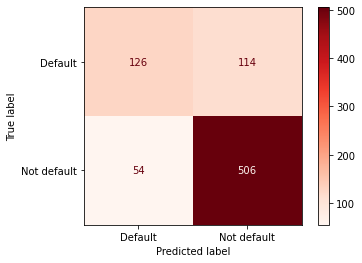

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


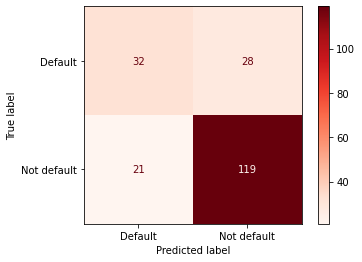

In [264]:
# comparing other Classification Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred_train = clf_logistic_regression.predict(X_train)
Y_pred = clf_logistic_regression.predict(X_test)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test, Y_pred, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression, X_train, Y_train, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(clf_logistic_regression, X_test, Y_test, cmap=plt.cm.Reds)
plt.show()

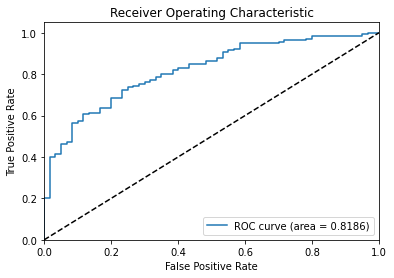

In [265]:
# very minor increase in AUC-roc from base by 0.004 points

import numpy as np
import matplotlib.pyplot as plt

# Run everytime we change data
Y_train_aug = np.array(Y_train)
Y_test_aug = np.array(Y_test)

# convert Y_test_aug to binary encoding if it is not already
Y_train_aug = np.where(Y_train_aug == 'Not default', 1, 0)
Y_test_aug = np.where(Y_test_aug == 'Not default', 1, 0)

Y_prob = clf_logistic_regression.predict_proba(X_test)[:, 1]

# convert Y_test_aug and Y_prob to NumPy arrays if they are not already
Y_prob = np.array(Y_prob)

# calculate false positive rate (fpr) and true positive rate (tpr) for ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_aug, Y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Observations for Base model:

1. We can see that we have good evaluation metrics for Non-default class vs Default; due to skewness in the data proportion and thus resulting in imbalance



2. Also , we see our major concern of losing money, due high risk of predicting defualts as non-defaults is still high due to low recall value across the default-class


In [266]:
X_test.head()

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_employment_since,installment_as_income_perc,sex,personal_status,...,present_residence_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
63,0 <= ... < 200 DM,48,no credits taken/ all credits paid back duly,business,14421,... < 100 DM,1 <= ... < 4 years,2,male,single,...,2,"if not A121/A122 : car or other, not in attrib...",25,none,own,1,skilled employee / official,1,"yes, registered under the customers name",yes
69,no checking account,36,existing credits paid back duly till now,domestic appliances,2394,unknown/ no savings account,1 <= ... < 4 years,4,female,divorced,...,4,"if not A121/A122 : car or other, not in attrib...",25,none,own,1,skilled employee / official,1,none,yes
182,< 0 DM,21,all credits at this bank paid back duly,car (new),1647,unknown/ no savings account,1 <= ... < 4 years,4,male,single,...,2,if not A121 : building society savings agreeme...,40,none,own,2,unskilled - resident,2,none,yes
314,>= 200 DM / salary assignments for at least 1 ...,4,existing credits paid back duly till now,car (new),1494,unknown/ no savings account,... < 1 year,1,male,single,...,2,real estate,29,none,own,1,unskilled - resident,2,none,no
306,no checking account,30,existing credits paid back duly till now,car (used),4811,unknown/ no savings account,4 <= ... < 7 years,2,female,divorced,...,4,if not A121 : building society savings agreeme...,24,stores,rent,1,unskilled - resident,1,none,yes


In [267]:
X_test.dtypes

account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_employment_since      object
installment_as_income_perc     int64
sex                           object
personal_status               object
other_debtors                 object
present_residence_since        int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [268]:
# Creating a dictionary to store the accuracy of each sub-category
accuracy_dict_base = {}

# Iterate over each column in the test data
for col in X_test.columns:

    # Check if the column is a categorical column
    if X_test[col].dtype == 'object':
        col_accuracy_dict = {}
        
        sub_cats = X_test[col].unique()
        
        for sub_cat in sub_cats:
            
            idx = (X_test[col] == sub_cat)

            # Get the predictions for the sub-category
            sub_cat_preds = Y_pred[idx]

            # Calculate the accuracy of the sub-category
            sub_cat_accuracy = np.mean(sub_cat_preds == Y_test[idx])

            # Add the accuracy of the sub-category to the dictionary
            col_accuracy_dict[sub_cat] = [sub_cat_accuracy]

        # Add the accuracy dictionary of the column to the main dictionary
        accuracy_dict_base[col] = col_accuracy_dict

        
print(accuracy_dict_base)

{'account_check_status': {'0 <= ... < 200 DM': [0.6842105263157895], 'no checking account': [0.8823529411764706], '< 0 DM': [0.6440677966101694], '>= 200 DM / salary assignments for at least 1 year': [0.875]}, 'credit_history': {'no credits taken/ all credits paid back duly': [0.6666666666666666], 'existing credits paid back duly till now': [0.7628865979381443], 'all credits at this bank paid back duly': [0.47368421052631576], 'critical account/ other credits existing (not at this bank)': [0.8870967741935484], 'delay in paying off in the past': [0.5384615384615384]}, 'purpose': {'business': [0.7083333333333334], 'domestic appliances': [0.803921568627451], 'car (new)': [0.7317073170731707], 'car (used)': [0.9230769230769231], 'education': [0.6], 'radio/television': [0.7209302325581395], 'furniture/equipment': [0.5], '(vacation - does not exist?)': [0.5], 'retraining': [1.0], 'repairs': [0.3333333333333333]}, 'savings': {'... < 100 DM': [0.7586206896551724], 'unknown/ no savings account'

1. `credit_history == ”all credits at this bank paid back duly”` 
2. `purpose== ”Other”` 
3. `duration_in_month==36` 
4. `account_check_status == "<0 DM”` 

In [269]:
!pip install -q prettytable
!pip install --upgrade -q ipywidgets

In [270]:
from prettytable import PrettyTable
from ipywidgets import interact, interactive, fixed

# import dash
# import dash_table
# import qgrid

# Define the table headers
table = PrettyTable()
table.field_names = ["Feature", "Sub-Category", "Accuracy","Comments"]
table.align = "l"
table.max_width["Feature"] = 20
table.max_width["Sub-category"] = 45
table.max_width["Accuracy"] = 10
table.max_width["Comments"] = 30

# Loop through the dictionary and add rows to the table
for feature, sub_dict in accuracy_dict_base.items():
    for sub_category, accuracy in sub_dict.items():
        comment = "Bad" if accuracy[0] <0.7 else "Works"
        table.add_row([feature, sub_category, round(accuracy[0], 4), comment])
        
        
df = pd.DataFrame(table._rows)
df.columns = table.field_names


def display_table(df):
    display(df)

interactive_table = interactive(display_table, df=fixed(df))
interactive_table



interactive(children=(Output(),), _dom_classes=('widget-interact',))

# Dataset: Features

### Numeric Features: Feature engineering

In [313]:
train_data.describe()

,duration_in_month,credit_amount,installment_as_income_perc,present_residence_since,age,credits_this_bank,people_under_maintenance,monthly_debt_payments,log_credit_amount
count,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000
mean,20.486250,3181.807500,2.992500,2.821250,35.40375,1.411250,1.15250,168.753554,7.762779
std,11.568583,2756.190195,1.120944,1.100369,11.17707,0.578828,0.35973,166.030982,0.773700
min,4.000000,250.000000,1.000000,1.000000,19.00000,1.000000,1.00000,24.055556,5.521461
25%,12.000000,1332.500000,2.000000,2.000000,27.00000,1.000000,1.00000,85.881944,7.194812
50%,18.000000,2281.500000,3.000000,3.000000,33.00000,1.000000,1.00000,128.361111,7.732588
75%,24.000000,3864.250000,4.000000,4.000000,42.00000,2.000000,1.00000,201.608333,8.259523
max,60.000000,18424.000000,4.000000,4.000000,75.00000,4.000000,2.00000,2482.666667,9.821409


In [314]:
train_data.columns

Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'credit_amount', 'savings', 'present_employment_since',
       'installment_as_income_perc', 'sex', 'personal_status', 'other_debtors',
       'present_residence_since', 'property', 'age', 'other_installment_plans',
       'housing', 'credits_this_bank', 'job', 'people_under_maintenance',
       'telephone', 'foreign_worker', 'default', 'monthly_debt_payments',
       'log_credit_amount', 'monthly_dbt_cat', 'crdt_amt_cat', 'age_cat',
       'dur_mon_cat', 'inst_incm_perc_cat', 'pr_res_cat', 'crdt_bnk_cat'],
      dtype='object')

In [273]:
# monthly_debt_payments
train_data.loc[:, 'monthly_debt_payments'] = train_data.loc[:,'credit_amount'] / train_data.loc[:,'duration_in_month']

# log-transform Credit amount to reduce tail length
'''
Taking the logarithm of the credit_amount feature could help create a more linear relationship 
between the feature and the target variable, which could improve model performance.
'''
train_data.loc[:,'log_credit_amount'] = train_data.loc[:,'credit_amount'].apply(lambda x : np.log(x))

# Binning age and loan durations

'''
Instead of using the continuous feature only, 
we can try and create binned variables to capture the impact of the duration on credit risk

'''

#amount binning, keeps and includes upper binning threshold
dbt_interval = (0, 25, 50, 100, 200, 100000)
amt_interval = (0, 250, 1000, 2500, 4500, 1000000)
amt_cats = ['very_low', 'low' ,'medium', 'high', 'very_high']

train_data["monthly_dbt_cat"] = pd.cut(train_data.monthly_debt_payments, dbt_interval, labels=amt_cats)
train_data["crdt_amt_cat"] = pd.cut(train_data.credit_amount, amt_interval, labels=amt_cats)


#age binning, keeps and includes upper binning threshold
age_interval = (18, 25, 35, 45, 55, 100)
age_cats = ['student', 'young', 'adult', 'senior', 'elder']

train_data["age_cat"] = pd.cut(train_data.age, age_interval, labels=age_cats)

#loan duration, keeps and includes upper binning threshold
dur_interval = (0, 12, 24, 36, 48, 60)
dur_cats = ['very_short', 'short' ,'medium', 'long', 'very_long']
train_data["dur_mon_cat"] = pd.cut(train_data.duration_in_month, dur_interval, labels=dur_cats)

# Creating categorical feature for 'installment_as_income_perc', 'present_residence_since'
# 'credits_this_bank'
inst_interval = (0, 1, 2, 3, 4)
inst_cats = ['low' ,'lower-mid', 'mid-high', 'high']
train_data["inst_incm_perc_cat"] = pd.cut(train_data.installment_as_income_perc, inst_interval, labels=inst_cats)
train_data["pr_res_cat"] = pd.cut(train_data.present_residence_since, inst_interval, labels=inst_cats)
train_data["crdt_bnk_cat"] = pd.cut(train_data.credits_this_bank, inst_interval, labels=inst_cats)

inst_interval2 = (0, 1, 2)
inst_cats2 = ['low' , 'high']
train_data["crdt_bnk_cat"] = pd.cut(train_data.people_under_maintenance, inst_interval2, labels=inst_cats2)

train_data.head()

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_employment_since,installment_as_income_perc,sex,personal_status,...,default,monthly_debt_payments,log_credit_amount,monthly_dbt_cat,crdt_amt_cat,age_cat,dur_mon_cat,inst_incm_perc_cat,pr_res_cat,crdt_bnk_cat
527,no checking account,4,critical account/ other credits existing (not ...,domestic appliances,1503,... < 100 DM,4 <= ... < 7 years,2,male,single,...,Not default,375.750000,7.315218,very_high,medium,adult,very_short,lower-mid,low,high
557,no checking account,21,no credits taken/ all credits paid back duly,car (new),5003,unknown/ no savings account,1 <= ... < 4 years,1,female,divorced,...,Default,238.238095,8.517793,very_high,very_high,young,short,low,high,low
653,0 <= ... < 200 DM,36,delay in paying off in the past,car (new),8086,100 <= ... < 500 DM,.. >= 7 years,2,male,single,...,Default,224.611111,8.997889,very_high,very_high,adult,medium,lower-mid,high,low
301,0 <= ... < 200 DM,36,no credits taken/ all credits paid back duly,domestic appliances,3804,... < 100 DM,1 <= ... < 4 years,4,female,divorced,...,Default,105.666667,8.243808,high,high,adult,medium,high,low,low
440,no checking account,12,existing credits paid back duly till now,car (new),1884,... < 100 DM,.. >= 7 years,4,male,single,...,Not default,157.000000,7.541152,high,medium,adult,very_short,high,high,low


In [274]:
train_data.columns

Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'credit_amount', 'savings', 'present_employment_since',
       'installment_as_income_perc', 'sex', 'personal_status', 'other_debtors',
       'present_residence_since', 'property', 'age', 'other_installment_plans',
       'housing', 'credits_this_bank', 'job', 'people_under_maintenance',
       'telephone', 'foreign_worker', 'default', 'monthly_debt_payments',
       'log_credit_amount', 'monthly_dbt_cat', 'crdt_amt_cat', 'age_cat',
       'dur_mon_cat', 'inst_incm_perc_cat', 'pr_res_cat', 'crdt_bnk_cat'],
      dtype='object')

In [275]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 527 to 405
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   account_check_status        800 non-null    object  
 1   duration_in_month           800 non-null    int64   
 2   credit_history              800 non-null    object  
 3   purpose                     800 non-null    object  
 4   credit_amount               800 non-null    int64   
 5   savings                     800 non-null    object  
 6   present_employment_since    800 non-null    object  
 7   installment_as_income_perc  800 non-null    int64   
 8   sex                         800 non-null    object  
 9   personal_status             800 non-null    object  
 10  other_debtors               800 non-null    object  
 11  present_residence_since     800 non-null    int64   
 12  property                    800 non-null    object  
 13  age               

In [276]:
# Extend column types

column_types_new = column_types

print(column_types_new.keys())
print('\n')
print(train_data.columns)

cols_to_add = list(train_data.columns[~pd.Series(list(train_data.columns)).isin(list(column_types_new.keys()))])
print(cols_to_add)

for c in cols_to_add:
    if train_data.dtypes[c] in ('category', 'object'):
        column_types_new[c] = 'category'
    elif train_data.dtypes[c] in ('int64', 'float64'):
        column_types_new[c] = 'numeric'
    else:
        column_types_new[c] = 'undefined'
        
column_types_new

dict_keys(['default', 'account_check_status', 'duration_in_month', 'credit_history', 'purpose', 'credit_amount', 'savings', 'present_employment_since', 'installment_as_income_perc', 'sex', 'personal_status', 'other_debtors', 'present_residence_since', 'property', 'age', 'other_installment_plans', 'housing', 'credits_this_bank', 'job', 'people_under_maintenance', 'telephone', 'foreign_worker'])


Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'credit_amount', 'savings', 'present_employment_since',
       'installment_as_income_perc', 'sex', 'personal_status', 'other_debtors',
       'present_residence_since', 'property', 'age', 'other_installment_plans',
       'housing', 'credits_this_bank', 'job', 'people_under_maintenance',
       'telephone', 'foreign_worker', 'default', 'monthly_debt_payments',
       'log_credit_amount', 'monthly_dbt_cat', 'crdt_amt_cat', 'age_cat',
       'dur_mon_cat', 'inst_incm_perc_cat', 'pr_res_cat', 'crdt_bnk_cat'],


{'default': 'category',
 'account_check_status': 'category',
 'duration_in_month': 'numeric',
 'credit_history': 'category',
 'purpose': 'category',
 'credit_amount': 'numeric',
 'savings': 'category',
 'present_employment_since': 'category',
 'installment_as_income_perc': 'numeric',
 'sex': 'category',
 'personal_status': 'category',
 'other_debtors': 'category',
 'present_residence_since': 'numeric',
 'property': 'category',
 'age': 'numeric',
 'other_installment_plans': 'category',
 'housing': 'category',
 'credits_this_bank': 'numeric',
 'job': 'category',
 'people_under_maintenance': 'numeric',
 'telephone': 'category',
 'foreign_worker': 'category',
 'monthly_debt_payments': 'numeric',
 'log_credit_amount': 'numeric',
 'monthly_dbt_cat': 'category',
 'crdt_amt_cat': 'category',
 'age_cat': 'category',
 'dur_mon_cat': 'category',
 'inst_incm_perc_cat': 'category',
 'pr_res_cat': 'category',
 'crdt_bnk_cat': 'category'}

In [277]:
# preparing test data

# monthly_debt_payments
test_data.loc[:, 'monthly_debt_payments'] = test_data.loc[:,'credit_amount'] / test_data.loc[:,'duration_in_month']

# log-transform Credit amount to reduce tail length
'''
Taking the logarithm of the credit_amount feature could help create a more linear relationship 
between the feature and the target variable, which could improve model performance.
'''
test_data.loc[:,'log_credit_amount'] = test_data.loc[:,'credit_amount'].apply(lambda x : np.log(x))

# Binning age and loan durations

'''
Instead of using the continuous feature only, 
we can try and create binned variables to capture the impact of the duration on credit risk

'''

#amount binning, keeps and includes upper binning threshold
dbt_interval = (0, 25, 50, 100, 200, 100000)
amt_interval = (0, 250, 1000, 2500, 4500, 1000000)
amt_cats = ['very_low', 'low' ,'medium', 'high', 'very_high']

test_data["monthly_dbt_cat"] = pd.cut(test_data.monthly_debt_payments, dbt_interval, labels=amt_cats)
test_data["crdt_amt_cat"] = pd.cut(test_data.credit_amount, amt_interval, labels=amt_cats)


#age binning, keeps and includes upper binning threshold
age_interval = (18, 25, 35, 45, 55, 100)
age_cats = ['student', 'young', 'adult', 'senior', 'elder']

test_data["age_cat"] = pd.cut(test_data.age, age_interval, labels=age_cats)

#loan duration, keeps and includes upper binning threshold
dur_interval = (0, 12, 24, 36, 48, 60)
dur_cats = ['very_short', 'short' ,'medium', 'long', 'very_long']
test_data["dur_mon_cat"] = pd.cut(test_data.duration_in_month, dur_interval, labels=dur_cats)

# Creating categorical feature for 'installment_as_income_perc', 'present_residence_since'
# 'credits_this_bank'
inst_interval = (0, 1, 2, 3, 4)
inst_cats = ['low' ,'lower-mid', 'mid-high', 'high']
test_data["inst_incm_perc_cat"] = pd.cut(test_data.installment_as_income_perc, inst_interval, labels=inst_cats)
test_data["pr_res_cat"] = pd.cut(test_data.present_residence_since, inst_interval, labels=inst_cats)
test_data["crdt_bnk_cat"] = pd.cut(test_data.credits_this_bank, inst_interval, labels=inst_cats)

inst_interval2 = (0, 1, 2)
inst_cats2 = ['low' , 'high']
test_data["crdt_bnk_cat"] = pd.cut(test_data.people_under_maintenance, inst_interval2, labels=inst_cats2)

test_data.head()

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_employment_since,installment_as_income_perc,sex,personal_status,...,default,monthly_debt_payments,log_credit_amount,monthly_dbt_cat,crdt_amt_cat,age_cat,dur_mon_cat,inst_incm_perc_cat,pr_res_cat,crdt_bnk_cat
63,0 <= ... < 200 DM,48,no credits taken/ all credits paid back duly,business,14421,... < 100 DM,1 <= ... < 4 years,2,male,single,...,Default,300.437500,9.576441,very_high,very_high,student,long,lower-mid,lower-mid,low
69,no checking account,36,existing credits paid back duly till now,domestic appliances,2394,unknown/ no savings account,1 <= ... < 4 years,4,female,divorced,...,Not default,66.500000,7.780721,medium,medium,student,medium,high,high,low
182,< 0 DM,21,all credits at this bank paid back duly,car (new),1647,unknown/ no savings account,1 <= ... < 4 years,4,male,single,...,Default,78.428571,7.406711,medium,medium,adult,short,high,lower-mid,high
314,>= 200 DM / salary assignments for at least 1 ...,4,existing credits paid back duly till now,car (new),1494,unknown/ no savings account,... < 1 year,1,male,single,...,Not default,373.500000,7.309212,very_high,medium,young,very_short,low,lower-mid,high
306,no checking account,30,existing credits paid back duly till now,car (used),4811,unknown/ no savings account,4 <= ... < 7 years,2,female,divorced,...,Not default,160.366667,8.478660,high,very_high,student,medium,lower-mid,high,low


In [278]:
test_data.columns

Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'credit_amount', 'savings', 'present_employment_since',
       'installment_as_income_perc', 'sex', 'personal_status', 'other_debtors',
       'present_residence_since', 'property', 'age', 'other_installment_plans',
       'housing', 'credits_this_bank', 'job', 'people_under_maintenance',
       'telephone', 'foreign_worker', 'default', 'monthly_debt_payments',
       'log_credit_amount', 'monthly_dbt_cat', 'crdt_amt_cat', 'age_cat',
       'dur_mon_cat', 'inst_incm_perc_cat', 'pr_res_cat', 'crdt_bnk_cat'],
      dtype='object')

In [317]:
# # Prepare augmented train and test data with no feature removals
# drop_cols1 = ['default']
# X_train_ft = train_data.copy(deep=True).drop(columns= drop_cols1)
# Y_train_ft = train_data['default']

# X_test_ft = test_data.copy(deep=True).drop(columns= drop_cols1)
# Y_test_ft = test_data['default']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# print(X_train_ft.shape, Y_train_ft.shape)
# print(X_test_ft.shape, Y_test_ft.shape)

(800, 21) (800,)
(200, 21) (200,)


In [318]:
# Prepare augmented train and test data with feature removals

# drop_cols = ['default','installment_as_income_perc','credit_amount','age', 'duration_in_month']
drop_cols = ['default']
X_train_new = train_data.copy(deep=True).drop(columns= drop_cols)
Y_train_new = train_data['default']

X_test_new = test_data.copy(deep=True).drop(columns= drop_cols)
Y_test_new = test_data['default']


print(X_train_new.shape, Y_train_new.shape)
print(X_test_new.shape, Y_test_new.shape)

(800, 30) (800,)
(200, 30) (200,)


# Final Feature pre-processing pipeline + Model

### WOE Encoder

Target encoding like WoE is typically applied only to categorical features. It involves replacing the categories of a categorical feature with a numerical value based on the target variable.

In [319]:
!pip install -q category_encoders
import category_encoders as ce

In [320]:
feature_types

{'account_check_status': 'category',
 'duration_in_month': 'numeric',
 'credit_history': 'category',
 'purpose': 'category',
 'credit_amount': 'numeric',
 'savings': 'category',
 'present_employment_since': 'category',
 'installment_as_income_perc': 'numeric',
 'sex': 'category',
 'personal_status': 'category',
 'other_debtors': 'category',
 'present_residence_since': 'numeric',
 'property': 'category',
 'age': 'numeric',
 'other_installment_plans': 'category',
 'housing': 'category',
 'credits_this_bank': 'numeric',
 'job': 'category',
 'people_under_maintenance': 'numeric',
 'telephone': 'category',
 'foreign_worker': 'category'}

### Checking variable importance for base logistic model

In [283]:
!pip install -q statsmodels

In [322]:
# Adding WOE only

import category_encoders as ce

# # Pipeline to fill missing values, transform and scale the numeric columns
# columns_to_scale = [key for key in feature_types.keys() if feature_types[key] == "numeric"]
# numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# # Pipeline to fill missing values and WOE encode the categorical values
# columns_to_encode = [key for key in feature_types.keys() if feature_types[key] == "category"]

# categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                     ('woe', ce.WOEEncoder())])



# feature_types is used to declare the features the model is trained on
feature_types_new = {i:column_types_new[i] for i in column_types_new if i not in drop_cols}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types_new.keys() if feature_types_new[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and WOE encode the categorical values
columns_to_encode = [key for key in feature_types_new.keys() if feature_types_new[key] == "category"]

categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('woe', ce.WOEEncoder())
                                   ])


# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                              ('cat', categorical_transformer, columns_to_encode)
                                              ])


In [323]:
# checking variable significance
import statsmodels.api as sm

# Run everytime we change data
Y_train_aug = np.array(Y_train)
Y_test_aug = np.array(Y_test)

# convert Y_test_aug to binary encoding if it is not already
Y_train_aug = np.where(Y_train_aug == 'Not default', 1, 0)
Y_test_aug = np.where(Y_test_aug == 'Not default', 1, 0)

X_train_trans = preprocessor.fit_transform(X_train_new, Y_train_aug)
print(X_train_trans.shape)
X_train_trans

logit_clf = sm.Logit(Y_train_aug, X_train_trans)

result = logit_clf.fit(maxiter=1000)

print(result.summary())

(800, 30)
Optimization terminated successfully.
         Current function value: 0.455457
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      770
Method:                           MLE   Df Model:                           29
Date:                Wed, 03 May 2023   Pseudo R-squ.:                  0.2544
Time:                        15:25:43   Log-Likelihood:                -364.37
converged:                       True   LL-Null:                       -488.69
Covariance Type:            nonrobust   LLR p-value:                 9.300e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7455      0.339     -2.197      0.028      -1.411      -0.080
x2            -0.21

In [346]:
# Keep variables with decent significance, best would be p<0.05, but since it results in very simple model kept at 0.3
p_val = (result.pvalues)

keep_vars = np.where(p_val < 0.3)

cols = X_train_new.columns

final_fts = cols[keep_vars]

print(cols)

print('\n')

print(final_fts)

Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'credit_amount', 'savings', 'present_employment_since',
       'installment_as_income_perc', 'sex', 'personal_status', 'other_debtors',
       'present_residence_since', 'property', 'age', 'other_installment_plans',
       'housing', 'credits_this_bank', 'job', 'people_under_maintenance',
       'telephone', 'foreign_worker', 'monthly_debt_payments',
       'log_credit_amount', 'monthly_dbt_cat', 'crdt_amt_cat', 'age_cat',
       'dur_mon_cat', 'inst_incm_perc_cat', 'pr_res_cat', 'crdt_bnk_cat'],
      dtype='object')


Index(['account_check_status', 'credit_history', 'credit_amount', 'savings',
       'present_employment_since', 'other_debtors', 'present_residence_since'],
      dtype='object')


In [347]:
X_train_new[final_fts].head()

,account_check_status,credit_history,credit_amount,savings,present_employment_since,other_debtors,present_residence_since
527,no checking account,critical account/ other credits existing (not ...,1503,... < 100 DM,4 <= ... < 7 years,none,1
557,no checking account,no credits taken/ all credits paid back duly,5003,unknown/ no savings account,1 <= ... < 4 years,none,4
653,0 <= ... < 200 DM,delay in paying off in the past,8086,100 <= ... < 500 DM,.. >= 7 years,none,4
301,0 <= ... < 200 DM,no credits taken/ all credits paid back duly,3804,... < 100 DM,1 <= ... < 4 years,none,1
440,no checking account,existing credits paid back duly till now,1884,... < 100 DM,.. >= 7 years,none,4


In [348]:

# X_train2 = X_train_new[final_fts].copy(deep = True)


# # Pipeline to fill missing values, transform and scale the numeric columns
# columns_to_scale = [idx for idx, key in zip(X_train2.dtypes.index, X_train2.dtypes) 
#                     if key == "int64" or key == "float64"]
# numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# # Pipeline to fill missing values and WOE encode the categorical values
# columns_to_encode = [idx for idx, key in zip(X_train2.dtypes.index, X_train2.dtypes) 
#                     if key == "object"]

# categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                     ('woe', ce.WOEEncoder())])

# # Perform preprocessing of the columns with the above pipelines
# preprocessor2 = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
#                                               ('cat', categorical_transformer, columns_to_encode)
#                                               ])

# # Pipeline for the model Logistic Regression
# clf_logistic_regression2 = Pipeline(steps=[('preprocessor', preprocessor2),
#                                           ('classifier', LogisticRegression(max_iter=1000))])


In [349]:
# checking variable significance
import statsmodels.api as sm

X_train_trans = preprocessor2.fit_transform(X_train2, Y_train_aug)
print(X_train_trans.shape)
X_train_trans

logit_clf = sm.Logit(Y_train_aug, X_train_trans)

result = logit_clf.fit(maxiter=1000)

print(result.summary())

(800, 7)
Optimization terminated successfully.
         Current function value: 0.570028
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      793
Method:                           MLE   Df Model:                            6
Date:                Wed, 03 May 2023   Pseudo R-squ.:                 0.06685
Time:                        15:30:33   Log-Likelihood:                -456.02
converged:                       True   LL-Null:                       -488.69
Covariance Type:            nonrobust   LLR p-value:                 3.680e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3311      0.090     -3.695      0.000      -0.507      -0.155
x2            -0.113

#### only WOE based basic features model

In [352]:
# Adding WOE only

import category_encoders as ce

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and WOE encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key] == "category"]

categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('woe', ce.WOEEncoder())])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                              ('cat', categorical_transformer, columns_to_encode)])

# Pipeline for the model Logistic Regression
clf_logistic_regression2 = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', LogisticRegression(max_iter=1000))])


### Polynomial Features and Interaction Features 

In this code snippet, we first specify the degree of the polynomial features we want to create (in this case, degree=2). We then create an instance of the PolynomialFeatures transformer with this degree, and specify include_bias=False to exclude the bias term from the polynomial features.

We then fit and transform the training and testing datasets using this transformer to create the polynomial features. We do the same for the interaction features, but set the interaction_only parameter to True to create only interaction features.

In [36]:
# import category_encoders as ce
# from sklearn.feature_selection import SelectKBest, chi2, f_classif
# from sklearn.preprocessing import FunctionTransformer

# # feature_types is used to declare the features the model is trained on
# feature_types_new = {i:column_types_new[i] for i in column_types_new if i not in drop_cols}

# # Pipeline to fill missing values, transform and scale the numeric columns
# columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
# numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())
#                                ])

# # Pipeline to WOE encode the categorical columns
# columns_to_encode = [key for key in feature_types_new.keys() if feature_types_new[key] == "category"]
# categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                     ('woe', ce.WOEEncoder())
#                                    ])

# # Combine the transformers
# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
#                                                ('cat', categorical_transformer, columns_to_encode)
#                                               ])


# def interaction_features(X):
#     interaction_features = []
#     for i in range(X.shape[1]):
#         for j in range(i+1, X.shape[1]):
#             interaction_features.append(X[:, i] * X[:, j])
#     return np.column_stack(interaction_features)

# # Pipeline for the model Logistic Regression with feature selection and interaction features
# clf_logistic_regression2_1 = Pipeline(steps=[('preprocessor', preprocessor),
#                                           ('interaction_features', FunctionTransformer(interaction_features)),
#                                           ('feature_selection', SelectKBest(f_classif, k=10)),
#                                           ('classifier', LogisticRegression(max_iter=1000))
#                                          ]
#                                   )


In [353]:
# WOE + New_features {interaction features result in overfitting}

import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE

# feature_types is used to declare the features the model is trained on
feature_types_new = {i:column_types_new[i] for i in column_types_new if i not in drop_cols}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types_new.keys() if feature_types_new[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and WOE encode the categorical values
columns_to_encode = [key for key in feature_types_new.keys() if feature_types_new[key] == "category"]

categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('woe', ce.WOEEncoder())
                                   ])

# Pipeline to add interaction features to the numeric columns
interaction_transformer = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True))])
columns_to_transform = columns_to_scale + columns_to_encode

# Combine the transformers
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                               ('cat', categorical_transformer, columns_to_encode),
                                               ('interaction', interaction_transformer, columns_to_scale)
                                              ])

# Pipeline for the model Logistic Regression
clf_logistic_regression2_1 = Pipeline(steps=[('preprocessor', preprocessor),
                                             ('feature_selection', SelectKBest(f_classif, k=7)),
#                                              ('feature_Selection',RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=6)),
                                             ('classifier', LogisticRegression(max_iter=1000))
                                            ])



In [354]:
feature_types_new

{'account_check_status': 'category',
 'duration_in_month': 'numeric',
 'credit_history': 'category',
 'purpose': 'category',
 'credit_amount': 'numeric',
 'savings': 'category',
 'present_employment_since': 'category',
 'installment_as_income_perc': 'numeric',
 'sex': 'category',
 'personal_status': 'category',
 'other_debtors': 'category',
 'present_residence_since': 'numeric',
 'property': 'category',
 'age': 'numeric',
 'other_installment_plans': 'category',
 'housing': 'category',
 'credits_this_bank': 'numeric',
 'job': 'category',
 'people_under_maintenance': 'numeric',
 'telephone': 'category',
 'foreign_worker': 'category',
 'monthly_debt_payments': 'numeric',
 'log_credit_amount': 'numeric',
 'monthly_dbt_cat': 'category',
 'crdt_amt_cat': 'category',
 'age_cat': 'category',
 'dur_mon_cat': 'category',
 'inst_incm_perc_cat': 'category',
 'pr_res_cat': 'category',
 'crdt_bnk_cat': 'category'}

In [355]:
# WOE + New_features replacement + interaction features + Variance threshold + Regularizarion

import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline

feature_types_new = {i:column_types[i] for i in column_types if i not in drop_cols}


# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types_new.keys() if feature_types_new[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('var_thresh',VarianceThreshold(threshold=0.1)),
                                ('scaler', StandardScaler())
                               ])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types_new.keys() if feature_types_new[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('woe', ce.WOEEncoder())
])


# Pipeline to add interaction features to the numeric columns
interaction_transformer = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    VarianceThreshold(threshold=0.1)
)

# Combine the transformers
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                               ('cat', categorical_transformer, columns_to_encode),
                                               ('interaction', interaction_transformer, columns_to_scale)])


clf_logistic_regression3 = Pipeline(steps=[('preprocessor', preprocessor),
                                             ('reg_model', SelectFromModel(Ridge(alpha=3))),
                                           ('classifier', LogisticRegression(max_iter=1000))])

## SMOTE : Handling Class Imbalance

In [356]:
!pip install -q imblearn

In [357]:
# Adding random minority oversampling using SMOTE and SmoteTOMEK

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.combine import SMOTEENN, SMOTETomek

feature_types_new = {i:column_types[i] for i in column_types if i not in drop_cols}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types_new.keys() if feature_types_new[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('var_thresh',VarianceThreshold(threshold=0.1)),
                                ('scaler', StandardScaler())
                               ])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types_new.keys() if feature_types_new[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('woe', ce.WOEEncoder())
])

# Pipeline to add interaction features to the numeric columns
interaction_transformer = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    VarianceThreshold(threshold=0.1)
)

# Combine the transformers
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                               ('cat', categorical_transformer, columns_to_encode),
                                               ('interaction', interaction_transformer, columns_to_scale)])

# Pipeline for the model Logistic Regression
clf_logistic_regression4 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotetomek', SMOTETomek(sampling_strategy='minority', random_state=42)),
    ('reg_model', SelectFromModel(Ridge(alpha=3))),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [358]:
# Basic : WOE + all features + SMOTEtomek + interaction + Regularization

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.combine import SMOTEENN, SMOTETomek

feature_types_new = {i:column_types[i] for i in column_types if i not in drop_cols}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types_new.keys() if feature_types_new[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('var_thresh',VarianceThreshold(threshold=0.1)),
                                ('scaler', StandardScaler())
                               ])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types_new.keys() if feature_types_new[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('woe', ce.WOEEncoder())
])

# Pipeline to add interaction features to the numeric columns
interaction_transformer = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    VarianceThreshold(threshold=0.1)
)

# Combine the transformers
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                               ('cat', categorical_transformer, columns_to_encode),
                                               ('interaction', interaction_transformer, columns_to_scale)])

# Pipeline for the model Logistic Regression
clf_logistic_regression4_1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority',random_state=7)),
    ('reg_model', SelectFromModel(Ridge(alpha=3))),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [44]:
# # Basic : WOE + all features + SMOTEtomek 
# import category_encoders as ce

# # Pipeline to fill missing values, transform and scale the numeric columns
# columns_to_scale = [key for key in feature_types.keys() if feature_types[key] == "numeric"]
# numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# # Pipeline to fill missing values and WOE encode the categorical values
# columns_to_encode = [key for key in feature_types.keys() if feature_types[key] == "category"]

# categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                     ('woe', ce.WOEEncoder())])

# # Perform preprocessing of the columns with the above pipelines
# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
#                                               ('cat', categorical_transformer, columns_to_encode)])


# # Pipeline for the model Logistic Regression
# clf_logistic_regression4_2 = ImbPipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smotetomek', SMOTETomek(sampling_strategy='minority', random_state=42)),
#     ('classifier', LogisticRegression(max_iter=1000))
# ])


In [359]:
# Basic : WOE + all features + SMOTEtomek + calibration
import category_encoders as ce
from sklearn.calibration import CalibratedClassifierCV

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and WOE encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key] == "category"]

categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('woe', ce.WOEEncoder())])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, columns_to_scale),
                                              ('cat', categorical_transformer, columns_to_encode)])

# Pipeline for the model Logistic Regression
clf_logistic_regression4_2 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotetomek', SMOTETomek(sampling_strategy='minority', random_state=42)),
    ('classifier', CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=1000), cv=5, method='sigmoid'))
])


### Model runs

In [377]:
# Run everytime we change data
Y_train_aug = np.array(Y_train)
Y_test_aug = np.array(Y_test)

Y_train_new_aug = np.array(Y_train_new)
Y_test_new_aug = np.array(Y_test_new)

# convert Y_test_aug to binary encoding if it is not already
Y_train_aug = np.where(Y_train_aug == 'Not default', 1, 0)
Y_test_aug = np.where(Y_test_aug == 'Not default', 1, 0)

Y_train_new_aug = np.where(Y_train_new_aug == 'Not default', 1, 0)
Y_test_new_aug = np.where(Y_test_new_aug == 'Not default', 1, 0)


In [361]:
X_train.shape

(800, 21)

In [48]:
X_train_new.shape

(800, 30)

In [49]:
print((Y_train.shape))
Y_train.value_counts()

(800,)


Not default    560
Default        240
Name: default, dtype: int64

In [50]:
# weakbaseline due class-imbalance, treating predictions if all were majority class 
print("Weak baseline", Y_train[Y_train == 'Not default'].shape[0] / Y_train.shape[0])

Weak baseline 0.7


#### WOE + all base features

In [350]:
# Fit and score your model : Feature selected on p-value trial



# X_train2 = X_train_new[final_fts].copy(deep = True)
# X_test2 = X_test_new[final_fts].copy(deep = True)


# clf_logistic_regression2.fit(X_train2, Y_train_aug)

# # The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

# print("Train accuracy score: ", clf_logistic_regression2.score(X_train2, Y_train_aug))
# print("Test accuracy score: ", clf_logistic_regression2.score(X_test2, Y_test_aug))


Train accuracy score:  0.7575
Test accuracy score:  0.715


In [362]:
# Fit and score your model : updated with WOE + all fts 
## Slight improvement in accuracy by 10 bps

clf_logistic_regression2.fit(X_train, Y_train_aug)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

print("Train accuracy score: ", clf_logistic_regression2.score(X_train, Y_train_aug))
print("Test accuracy score: ", clf_logistic_regression2.score(X_test, Y_test_aug))


Train accuracy score:  0.7775
Test accuracy score:  0.765


Training Eval 
               precision    recall  f1-score   support

     Default       0.68      0.50      0.57       240
 Not default       0.81      0.90      0.85       560

    accuracy                           0.78       800
   macro avg       0.74      0.70      0.71       800
weighted avg       0.77      0.78      0.77       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.62      0.55      0.58        60
 Not default       0.82      0.86      0.84       140

    accuracy                           0.77       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.76      0.77      0.76       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


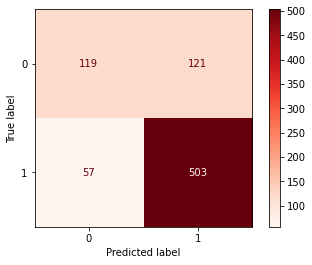

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


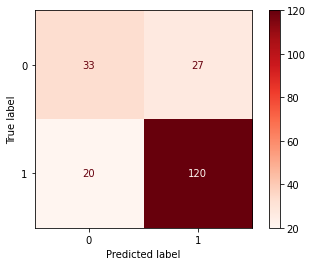

In [363]:
# comparing other Classification Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred_train = clf_logistic_regression2.predict(X_train)
Y_pred = clf_logistic_regression2.predict(X_test)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train_aug, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test_aug, Y_pred, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train_aug, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression2, X_train, Y_train_aug, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test_aug, Y_pred)
plot_confusion_matrix(clf_logistic_regression2, X_test, Y_test_aug, cmap=plt.cm.Reds)
plt.show()

#### WOE + base and new features + interactions

{bad perf, guess mostly due to overfit + multi-collnearity}

In [53]:
# Fit and score your model : updated with WOE + removed some to replace features + interaction {didn't improve much}
clf_logistic_regression2_1.fit(X_train_new, Y_train_new_aug)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

print("Train accuracy score: ", clf_logistic_regression2_1.score(X_train_new, Y_train_new_aug))
print("Test accuracy score: ", clf_logistic_regression2_1.score(X_test_new, Y_test_new_aug))


Train accuracy score:  0.75625
Test accuracy score:  0.755


Training Eval 
               precision    recall  f1-score   support

     Default       0.65      0.42      0.51       240
 Not default       0.78      0.90      0.84       560

    accuracy                           0.76       800
   macro avg       0.71      0.66      0.67       800
weighted avg       0.74      0.76      0.74       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.62      0.47      0.53        60
 Not default       0.79      0.88      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


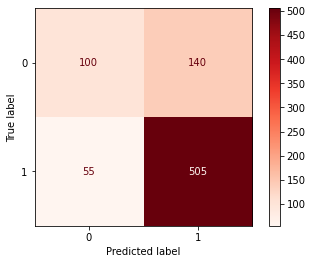

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


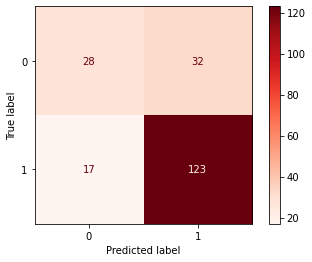

In [54]:
# comparing other Classification Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred_train = clf_logistic_regression2_1.predict(X_train_new)
Y_pred = clf_logistic_regression2_1.predict(X_test_new)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train_new_aug, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test_new_aug, Y_pred, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train_new_aug, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression2_1, X_train_new, Y_train_aug, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test_new_aug, Y_pred)
plot_confusion_matrix(clf_logistic_regression2_1, X_test_new, Y_test_aug, cmap=plt.cm.Reds)
plt.show()

####  WOE + removed redundant to replace with new features + interaction + regularization

{improved recall by 1 over only WOE benchmark}

In [364]:
# Fit and score your model : updated with WOE + removed some to replace features + interaction + regularization
# {improved recall by 1 over only WOE benchmark}
clf_logistic_regression3.fit(X_train_new, Y_train_new_aug)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

print("Train accuracy score: ", clf_logistic_regression3.score(X_train_new, Y_train_new_aug))
print("Test accuracy score: ", clf_logistic_regression3.score(X_test_new, Y_test_new_aug))


Train accuracy score:  0.77625
Test accuracy score:  0.75


Training Eval 
               precision    recall  f1-score   support

     Default       0.67      0.51      0.58       240
 Not default       0.81      0.89      0.85       560

    accuracy                           0.78       800
   macro avg       0.74      0.70      0.71       800
weighted avg       0.77      0.78      0.77       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.59      0.57      0.58        60
 Not default       0.82      0.83      0.82       140

    accuracy                           0.75       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.75      0.75      0.75       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


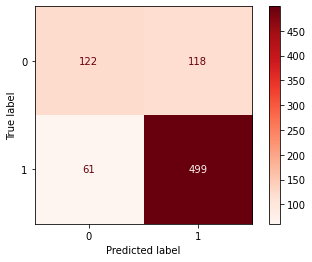

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


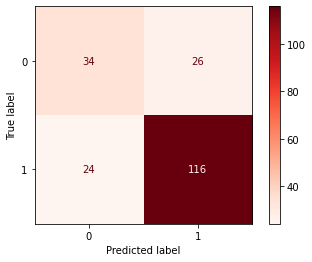

In [365]:
# comparing other Classification Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred_train = clf_logistic_regression3.predict(X_train_new)
Y_pred = clf_logistic_regression3.predict(X_test_new)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train_new_aug, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test_new_aug, Y_pred, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train_new_aug, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression3, X_train_new, Y_train_aug, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test_new_aug, Y_pred)
plot_confusion_matrix(clf_logistic_regression3, X_test_new, Y_test_aug, cmap=plt.cm.Reds)
plt.show()

#### Updated with WOE + removed some to replace redundant features + interaction + regularization + SMOTEtomek

{ Significant improvemet in Recall metrics for default and precision for non-default; although with reduction in overall accuracy, but F1-score remaining more or less similar}

calbration as what we wanted as per domain knowledge and business

In [366]:
# Fit and score your model : updated with WOE + removed features + interaction + regularization + SMOTE

clf_logistic_regression4.fit(X_train_new, Y_train_new_aug)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

print("Train accuracy score: ", clf_logistic_regression4.score(X_train_new, Y_train_new_aug))
print("Test accuracy score: ", clf_logistic_regression4.score(X_test_new, Y_test_new_aug))


Train accuracy score:  0.7425
Test accuracy score:  0.72


Training Eval 
               precision    recall  f1-score   support

     Default       0.55      0.75      0.64       240
 Not default       0.88      0.74      0.80       560

    accuracy                           0.74       800
   macro avg       0.71      0.75      0.72       800
weighted avg       0.78      0.74      0.75       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.52      0.82      0.64        60
 Not default       0.90      0.68      0.77       140

    accuracy                           0.72       200
   macro avg       0.71      0.75      0.70       200
weighted avg       0.78      0.72      0.73       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


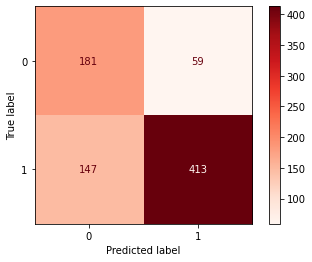

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


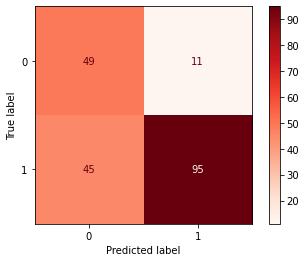

In [367]:
# comparing other Classification Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred_train = clf_logistic_regression4.predict(X_train_new)
Y_pred = clf_logistic_regression4.predict(X_test_new)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train_new_aug, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test_new_aug, Y_pred, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train_new_aug, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression4, X_train_new, Y_train_aug, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test_new_aug, Y_pred)
plot_confusion_matrix(clf_logistic_regression4, X_test_new, Y_test_aug, cmap=plt.cm.Reds)
plt.show()

#### Updated with WOE + removed some to replace redundant features + interaction + regularization + SMOTE

Here the test accuracy is aligned over previous SMOTEtomek method but at the cost of reduced precision-recall balance;

In [368]:
# Fit and score your model : updated with WOE + removed features + interaction + regularization + SMOTE

clf_logistic_regression4_1.fit(X_train_new, Y_train_new_aug)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

print("Train accuracy score: ", clf_logistic_regression4_1.score(X_train_new, Y_train_new_aug))
print("Test accuracy score: ", clf_logistic_regression4_1.score(X_test_new, Y_test_new_aug))


Train accuracy score:  0.7525
Test accuracy score:  0.71


Training Eval 
               precision    recall  f1-score   support

     Default       0.57      0.76      0.65       240
 Not default       0.88      0.75      0.81       560

    accuracy                           0.75       800
   macro avg       0.72      0.75      0.73       800
weighted avg       0.78      0.75      0.76       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.51      0.80      0.62        60
 Not default       0.89      0.67      0.76       140

    accuracy                           0.71       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.77      0.71      0.72       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


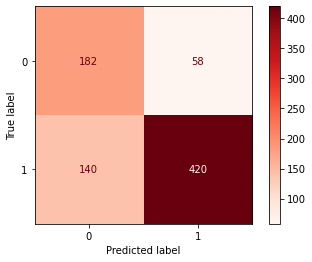

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


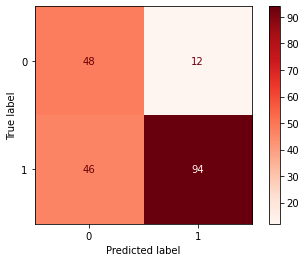

In [369]:
# comparing other Classification Evaluation metrics as well
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix

Y_pred_train = clf_logistic_regression4_1.predict(X_train_new)
Y_pred = clf_logistic_regression4_1.predict(X_test_new)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train_new_aug, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test_new_aug, Y_pred, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train_new_aug, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression4_1, X_train_new, Y_train_aug, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test_new_aug, Y_pred)
plot_confusion_matrix(clf_logistic_regression4_1, X_test_new, Y_test_aug, cmap=plt.cm.Reds)
plt.show()

####  Updated with WOE + all base features + SMOTEtomek 

{Slight improvement in accuracy over previous model, and precision-recall calibration as well}

In [370]:
# Fit and score your model : Updated with WOE + all features (no removal) + SMOTEtomek

clf_logistic_regression4_2.fit(X_train, Y_train_aug)

# The output is mean accuracy on the given test features and labels; which in my opinion is a wrong measure here

print("Train accuracy score: ", clf_logistic_regression4_2.score(X_train, Y_train_aug))
print("Test accuracy score: ", clf_logistic_regression4_2.score(X_test, Y_test_aug))


Train accuracy score:  0.74125
Test accuracy score:  0.735


In [101]:
# # comparing other Classification Evaluation metrics as well
# from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, plot_confusion_matrix
# from sklearn.metrics import precision_recall_curve

# def find_best_threshold(y_true, y_prob):
#     precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
#     fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)

#     # Calculate AUC-ROC
#     auc_roc = auc(fpr, tpr)

#     # Calculate F1 score
#     f1_scores = 2 * (precision * recall) / (precision + recall)

#     # Find the threshold that maximizes F1 score
#     best_threshold = thresholds[np.argmax(f1_scores)]

#     return best_threshold, auc_roc


# Y_prob_train = clf_logistic_regression4_2.predict_proba(X_train)[:, 1]

# best_threshold, auc_roc = find_best_threshold(Y_train_aug, Y_prob_train)
# # best_threshold, auc_roc = find_best_threshold(Y_test_aug, Y_prob)

# print("Best threshold:", best_threshold)
# print("AUC-ROC:", auc_roc)


Best threshold: 0.21915402595881087
AUC-ROC: 0.8146949404761905


Training Eval 
               precision    recall  f1-score   support

     Default       0.55      0.74      0.63       240
 Not default       0.87      0.74      0.80       560

    accuracy                           0.74       800
   macro avg       0.71      0.74      0.72       800
weighted avg       0.77      0.74      0.75       800

Test Eval 
               precision    recall  f1-score   support

     Default       0.54      0.85      0.66        60
 Not default       0.91      0.69      0.78       140

    accuracy                           0.73       200
   macro avg       0.73      0.77      0.72       200
weighted avg       0.80      0.73      0.75       200

Training CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


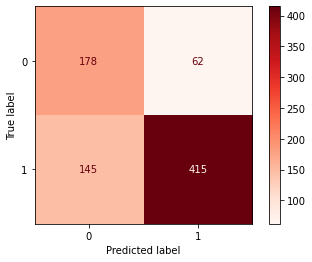

Test CF


/Users/pahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


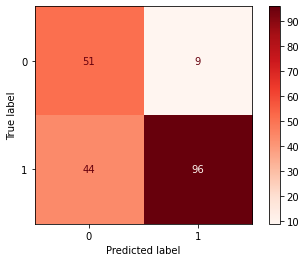

In [371]:
# comparing other Classification Evaluation metrics as well

Y_pred_train = clf_logistic_regression4_2.predict(X_train)
Y_pred_final = clf_logistic_regression4_2.predict(X_test)

# Manual probability threshold
# Y_pred_final = clf_logistic_regression4_2.predict(X_test)
# print(Y_pred_final)

# Y_prob = clf_logistic_regression4_2.predict_proba(X_test)[:, 1]
# Y_pred_final = Y_prob
# Y_pred_final = np.where(Y_prob < best_threshold, 0, 1)

# print(Y_pred_final)

# generate classification report
label_names = ['Default', 'Not default']

print("Training Eval \n", classification_report(Y_train_aug, Y_pred_train, target_names=label_names))
print("Test Eval \n", classification_report(Y_test_aug, Y_pred_final, target_names=label_names))

# generate confusion matrix

print("Training CF")
cm = confusion_matrix(Y_train_aug, Y_pred_train)
plot_confusion_matrix(clf_logistic_regression4_2, X_train, Y_train_aug, cmap=plt.cm.Reds)
plt.show()

print("Test CF")
cm = confusion_matrix(Y_test_aug, Y_pred_final)
plot_confusion_matrix(clf_logistic_regression4_2, X_test, Y_test_aug, cmap=plt.cm.Reds)
plt.show()

In [63]:
Y_pred_final

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1])

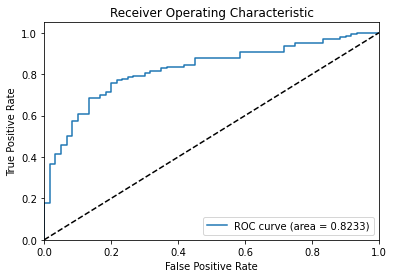

In [372]:
# very minor increase in AUC-roc from base (0.8186) to (0.8233) by 0.0043 points

import numpy as np
import matplotlib.pyplot as plt

Y_prob = clf_logistic_regression4_2.predict_proba(X_test)[:, 1]

# convert Y_test_aug and Y_prob to NumPy arrays if they are not already
Y_prob = np.array(Y_prob)

# calculate false positive rate (fpr) and true positive rate (tpr) for ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_aug, Y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [373]:
# shows there is still a scope to calibrate our final model output

from sklearn.metrics import brier_score_loss

# Calculate the Brier score for the uncalibrated and calibrated classifier on test data
y_pred = clf_logistic_regression.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(Y_test_aug, y_pred)
print("Brier score for uncalibrated classifier: {:.3f}".format(brier_score))

y_pred_platt = clf_logistic_regression4_2.predict_proba(X_test)[:, 1]
brier_score_platt = brier_score_loss(Y_test_aug, y_pred_platt)
print("Brier score for calibrated classifier: {:.3f}".format(brier_score_platt))

Brier score for uncalibrated classifier: 0.155
Brier score for calibrated classifier: 0.185


In [374]:

Y_pred = clf_logistic_regression.predict(X_test)
# Creating a dictionary to store the accuracy of each sub-category of test data
accuracy_dict_base_new = {}

# Iterate over each column in the test data
for col in X_test.columns:

    # Check if the column is a categorical column
    if X_test[col].dtype == 'object':
        col_accuracy_dict = {}
        
        sub_cats = X_test[col].unique()
        
        for sub_cat in sub_cats:
            
            idx = (X_test[col] == sub_cat)

            # Get the predictions for the sub-category
            sub_cat_preds = Y_pred[idx]
            sub_cat_preds_best = Y_pred_final[idx]

            # Calculate the accuracy of the sub-category
            sub_cat_accuracy = np.mean(sub_cat_preds == Y_test[idx])
            sub_cat_accuracy_best = np.mean(sub_cat_preds_best == Y_test_aug[idx])

            # Add the accuracy of the sub-category to the dictionary
            col_accuracy_dict[sub_cat] = [sub_cat_accuracy, sub_cat_accuracy_best]

        # Add the accuracy dictionary of the column to the main dictionary
        accuracy_dict_base_new[col] = col_accuracy_dict

        
print(accuracy_dict_base_new)

{'account_check_status': {'0 <= ... < 200 DM': [0.6842105263157895, 0.7017543859649122], 'no checking account': [0.8823529411764706, 0.8823529411764706], '< 0 DM': [0.6440677966101694, 0.5932203389830508], '>= 200 DM / salary assignments for at least 1 year': [0.875, 0.75]}, 'credit_history': {'no credits taken/ all credits paid back duly': [0.6666666666666666, 0.6666666666666666], 'existing credits paid back duly till now': [0.7628865979381443, 0.6907216494845361], 'all credits at this bank paid back duly': [0.47368421052631576, 0.7894736842105263], 'critical account/ other credits existing (not at this bank)': [0.8870967741935484, 0.8387096774193549], 'delay in paying off in the past': [0.5384615384615384, 0.5384615384615384]}, 'purpose': {'business': [0.7083333333333334, 0.7083333333333334], 'domestic appliances': [0.803921568627451, 0.803921568627451], 'car (new)': [0.7317073170731707, 0.7804878048780488], 'car (used)': [0.9230769230769231, 0.8846153846153846], 'education': [0.6, 0

In [375]:
from prettytable import PrettyTable
from ipywidgets import interact, interactive, fixed

# Define the table headers
table = PrettyTable()
table.field_names = ["Feature", "Sub-Category", "Accuracy","Comments", "Accuracy_aug", "Comments_new"]
table.align = "l"
table.max_width["Feature"] = 20
table.max_width["Sub-category"] = 45
table.max_width["Accuracy"] = 10
table.max_width["Comments"] = 30
table.max_width["Accuracy_aug"] = 10
table.max_width["Comments_new"] = 30

# Loop through the dictionary and add rows to the table
for feature, sub_dict in accuracy_dict_base_new.items():
    for sub_category, accuracy in sub_dict.items():
        comment = "Bad" if accuracy[0] <0.7 else "Works"
        comment2 = "Bad" if accuracy[1] <0.7 else "Works"
        table.add_row([feature, sub_category, round(accuracy[0], 4), comment, round(accuracy[1], 4),comment2])
        
        
df = pd.DataFrame(table._rows)
df.columns = table.field_names


def display_table(df):
    display(df)

interactive_table = interactive(display_table, df=fixed(df))
interactive_table



interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [376]:
print(df.Comments.value_counts())

print(df.Comments_new.value_counts())

Works    37
Bad      18
Name: Comments, dtype: int64
Works    38
Bad      17
Name: Comments_new, dtype: int64
